### Imports

In [1]:
#arrays 
import pandas as pd
import numpy as np

# plots
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import mutual_info_classif
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV,train_test_split,cross_val_score,cross_validate
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, roc_auc_score,roc_curve, auc, brier_score_loss
from sklearn import tree
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from itertools import cycle
from sklearn.metrics import confusion_matrix
import pydotplus
import graphviz

import keras
import tensorflow as tf
import tensorflow_probability as tfp

from keras.layers import Dense, Input, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, Embedding
from tensorflow.keras import backend as K

#NN
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

2023-03-29 10:49:51.108022: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Helper Module

In [2]:
class ModelEvaluator:
    def __init__(self):
        pass

    @staticmethod
    def y_roc(estimator, X):
        return [item[1] for item in estimator.predict(X)]

    @staticmethod
    def y_roc_regression(estimator, X):
        return estimator.predict(X).tolist()

    def cv_roc_plot(self, estimator, X, y):
        cv = StratifiedKFold(n_splits=4, shuffle=False)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        for train, test in cv.split(X, y):
            prediction = estimator.fit(X.iloc[train], y.iloc[train]).predict(X.iloc[test])
            fpr, tpr, t = roc_curve(y.iloc[test], prediction[:, 1])
            tpr[0] = 0
            tpr[-1] = 1
            tprs.append(interp(mean_fpr, fpr, tpr))
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
        mean_tpr = np.mean(tprs, axis=0)
        mean_auc = auc(mean_fpr, mean_tpr)
        return mean_fpr, mean_tpr, mean_auc

    @staticmethod
    def brier_score(y_prob_raw, y_true):
        y_prob = [prob[1] for prob in y_prob_raw]
        if len(y_prob) != len(y_true):
            print('Error: two lists must have same length')
            return
        return np.mean([(prob_1 - y) ** 2 for prob_1, y in zip(y_prob, y_true)])

    @staticmethod
    def get_prob_1(y_prob_raw):
        return [prob[1] for prob in y_prob_raw]

    @staticmethod
    def aver_prob(prob_lists):
        return np.mean(np.array(prob_lists), axis=0)

    @staticmethod
    def plot_confusion_matrix(matrix, title=""):
        sns.heatmap(data=matrix, annot=True, cmap="spring")
        status = ["0", "1"]
        axis_ticks = np.arange(len(status)) + 0.4
        plt.xticks(axis_ticks, status)
        plt.yticks(axis_ticks, status)
        plt.title(title)
        plt.ylabel("Actual Label")
        plt.xlabel("Predicted Label")


### Data Preprocessing

In [3]:
class RecidivismDataPreprocessor:
    def __init__(self, url):
        self.url = url
        self.recidivism = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def read_data(self):
        self.recidivism = pd.read_csv(self.url)

    def drop_columns(self, cols_2_drop):
        self.recidivism = self.recidivism.drop(cols_2_drop, axis=1)

    def preprocess_columns(self):
        self.recidivism['Residence_PUMA'] = self.recidivism['Residence_PUMA'].astype('category').cat.codes
        self.recidivism['Age_at_Release'] = self.recidivism['Age_at_Release'].apply(lambda x: int(x[:2]))
        self.recidivism['Dependents'] = self.recidivism['Dependents'].apply(lambda x: int(x[:1]))
        self.recidivism['Prior_Arrest_Episodes_Felony'] = self.recidivism['Prior_Arrest_Episodes_Felony'].apply(lambda x: int(x[:2]))
        self.recidivism['Prior_Arrest_Episodes_Drug'] = self.recidivism['Prior_Arrest_Episodes_Drug'].apply(lambda x: int(x[:2]))
        self.recidivism['Prior_Arrest_Episodes_Misd']=self.recidivism['Prior_Arrest_Episodes_Misd'].apply(lambda x: int(x[:2]))
        self.recidivism['Prior_Arrest_Episodes_Violent']=self.recidivism['Prior_Arrest_Episodes_Violent'].apply(lambda x: int(x[:2]))
        self.recidivism['Prior_Arrest_Episodes_Property']=self.recidivism['Prior_Arrest_Episodes_Property'].apply(lambda x: int(x[:2]))
        self.recidivism['Prior_Arrest_Episodes_PPViolationCharges']=self.recidivism['Prior_Arrest_Episodes_PPViolationCharges'].apply(lambda x: int(x[:2]))
        self.recidivism['Prior_Conviction_Episodes_Felony']=self.recidivism['Prior_Conviction_Episodes_Felony'].apply(lambda x: int(x[:1]))
        self.recidivism['Prior_Conviction_Episodes_Misd']=self.recidivism['Prior_Conviction_Episodes_Misd'].apply(lambda x: int(x[:1]))
        self.recidivism['Prior_Conviction_Episodes_Prop']=self.recidivism['Prior_Conviction_Episodes_Prop'].apply(lambda x: int(x[:1]))
        self.recidivism['Prior_Conviction_Episodes_Drug']=self.recidivism['Prior_Conviction_Episodes_Drug'].apply(lambda x: int(x[:1]))
        self.recidivism['Delinquency_Reports']=self.recidivism['Delinquency_Reports'].apply(lambda x: int(x[:1]))
        self.recidivism['Program_Attendances']=self.recidivism['Program_Attendances'].apply(lambda x: int(x[:2]))
        self.recidivism['Program_UnexcusedAbsences']=self.recidivism['Program_UnexcusedAbsences'].apply(lambda x: int(x[:1]))
        self.recidivism['Residence_Changes']=self.recidivism['Residence_Changes'].apply(lambda x: int(x[:1]))

    def scale_columns(self):
        scaler = StandardScaler()
        scaling_set = [column for column in self.recidivism.columns if self.recidivism[column].dtype in ['int64', 'float32', 'float64']]
        self.recidivism[scaling_set] = scaler.fit_transform(self.recidivism[scaling_set].values)
        self.recidivism.update(self.recidivism.select_dtypes(include=[object]).astype('category').apply(lambda x: x.cat.codes))

    def remove_outliers(self):
        self.recidivism = self.recidivism.dropna(subset=['Supervision_Risk_Score_First', 'Prison_Offense']).reset_index(drop=True)

    def impute_missing_values(self, columns_to_impute):
        for missing_column in columns_to_impute:
            test_index = self.recidivism[self.recidivism[missing_column] == -1].index
            train_index = self.recidivism[self.recidivism[missing_column] != -1].index
            X = self.recidivism.drop(columns=[missing_column])
            y = self.recidivism[missing_column].astype('int64')  # Ensure y is an integer type

            logreg = LogisticRegression()
            logreg.fit(X.iloc[train_index, :], y[train_index])
            self.recidivism.loc[test_index, missing_column] = logreg.predict(X.iloc[test_index, :])
            self.recidivism[missing_column] = self.recidivism[missing_column].astype('category').cat.codes


    def split_data(self, test_size=0.33, random_state=42):
        features = self.recidivism.drop(columns=["Recidivism_Within_3years"])
        target = self.recidivism.Recidivism_Within_3years

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            features, target, test_size=test_size, random_state=random_state)

    def convert_to_numpy(self):
        self.X_train = self.X_train.values
        self.X_test = self.X_test.values
        self.y_train = self.y_train.values
        self.y_test = self.y_test.values

    def preprocess(self):
        self.read_data()
        self.drop_columns(cols_2_drop)
        self.preprocess_columns()
        self.scale_columns()
        self.remove_outliers()
        self.impute_missing_values(['Supervision_Level_First', 'Prison_Offense'])
        self.split_data()
        self.convert_to_numpy()

# Usage example:
url = 'https://raw.githubusercontent.com/bswain7/MLP_Recidivism/nij_data/NIJ_s_Recidivism_Challenge_Full_Dataset.csv'
cols_2_drop =['Violations_ElectronicMonitoring',
       'Violations_Instruction', 'Violations_FailToReport',
       'Violations_MoveWithoutPermission',
       'Avg_Days_per_DrugTest', 'DrugTests_THC_Positive',
       'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
       'DrugTests_Other_Positive', 'Percent_Days_Employed', 'Jobs_Per_Year',
       'Employment_Exempt']

data_preprocessor = RecidivismDataPreprocessor(url)
data_preprocessor.preprocess()

# Access the preprocessed data
X_train = data_preprocessor.X_train
X_test = data_preprocessor.X_test
y_train = data_preprocessor.y_train
y_test = data_preprocessor.y_test



/Users/puddinpop/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/puddinpop/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [4]:
X_train

array([[0.9915745620139348, 0, 1, ..., False, False, 0.6580642757972365],
       [-1.6671730149464654, 1, 0, ..., False, False,
        -1.5196083981135624],
       [-0.16809055666905115, 1, 1, ..., False, False,
        0.6580642757972365],
       ...,
       [-1.6088983858669184, 0, 1, ..., False, False, 0.6580642757972365],
       [0.42009469950717687, 1, 0, ..., False, False, 0.6580642757972365],
       [1.5010243193449082, 1, 0, ..., True, False, 0.6580642757972365]],
      dtype=object)

### Model Training

##### Multi Layer Perceptron with Mean Sqaured Error

In [5]:
class MLPModel:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train.fillna(0).astype('float32')
        self.y_train = y_train.fillna(0)
        self.X_test = X_test.fillna(0).astype('float32')
        self.y_test = y_test
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        n_cols = self.X_train.shape[1]
        model.add(BatchNormalization(input_shape=(n_cols,)))
        model.add(Dense(70, activation='linear'))
        model.add(Dropout(0.3))
        model.add(Dense(50, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(50, activation='relu'))
        model.add(Dropout(0.3))
        model.add(BatchNormalization())
        model.add(Dense(2, activation='softmax'))

        sgd = keras.optimizers.SGD(lr=.001, decay=2e-4, momentum=0.9, nesterov=True)
        model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
        return model

    def train(self, patience=50, epochs=200):
        early_stopping_monitor = EarlyStopping(patience=patience)
        history = self.model.fit(self.X_train, self.y_train,
                                 validation_split=0.3, epochs=epochs, callbacks=[early_stopping_monitor])
        return history

    def evaluate(self):
        score = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        return score

    def fit(self):
        self.model.fit(self.X_train, self.y_train)




In [6]:
# Instantiate the data preprocessor and preprocess the data
data_preprocessor = RecidivismDataPreprocessor(url)
data_preprocessor.preprocess()

# Split the data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    data_preprocessor.recidivism.drop(['ID', 'Recidivism_Within_3years', 'Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3'], axis=1),
    data_preprocessor.recidivism['Recidivism_Arrest_Year1'], test_size=0.2)

# Instantiate the model evaluator
model_evaluator = ModelEvaluator()

# Instantiate and train the MLP model
mlp_model = MLPModel(X_train1, y_train1, X_test1, y_test1)
history = mlp_model.train()

# Evaluate the MLP model
score = mlp_model.evaluate()
mlp_model.fit()

# Calculate performance metrics
fpr, tpr, _ = roc_curve(y_test1, model_evaluator.y_roc(mlp_model.model, mlp_model.X_test))
train_brier_score = model_evaluator.brier_score(mlp_model.model.predict(mlp_model.X_train), y_train1)
test_brier_score = model_evaluator.brier_score(mlp_model.model.predict(mlp_model.X_test), y_test1)
auroc = roc_auc_score(y_test1, model_evaluator.y_roc(mlp_model.model, mlp_model.X_test))

# Print results
print('MLP train Brier score:', train_brier_score,
      '\n test Brier score:', test_brier_score,
      '\n AUROC:', auroc)

/Users/puddinpop/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/puddinpop/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Epoch 1/200
444/444 [==============================] - 4s 4ms/step - loss: 0.3175 - accuracy: 0.5102 - val_loss: 0.2644 - val_accuracy: 0.6023
Epoch 2/200
444/444 [==============================] - 2s 4ms/step - loss: 0.2888 - accuracy: 0.4964 - val_loss: 0.2549 - val_accuracy: 0.5901
Epoch 3/200
444/444 [==============================] - 2s 4ms/step - loss: 0.2682 - accuracy: 0.4890 - val_loss: 0.2514 - val_accuracy: 0.5694
Epoch 4/200
444/444 [==============================] - 2s 4ms/step - loss: 0.2573 - accuracy: 0.4949 - val_loss: 0.2504 - val_accuracy: 0.5497
Epoch 5/200
444/444 [==============================] - 1s 3ms/step - loss: 0.2526 - accuracy: 0.5017 - val_loss: 0.2501 - val_accuracy: 0.5339
Epoch 6/200
444/444 [==============================] - 2s 4ms/step - loss: 0.2509 - accuracy: 0.4900 - val_loss: 0.2500 - val_accuracy: 0.5221
Epoch 7/200
444/444 [==============================] - 2s 4ms/step - loss: 0.2504 - accuracy: 0.4959 - val_loss: 0.2500 - val_accuracy: 0.5190

#### Multi Layer Perceptron from Categorical Cross Entropy

In [7]:
class MLPModel:
    def __init__(self, input_shape, loss):
        self.model = Sequential()
        self.model.add(BatchNormalization(input_shape=input_shape))
        self.model.add(Dense(70, activation='linear'))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(50, activation='relu'))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(50, activation='relu'))
        self.model.add(Dropout(0.3))
        self.model.add(BatchNormalization())
        self.model.add(Dense(2, activation='softmax'))
        self.evaluator = ModelEvaluator()

        self.early_stopping_monitor = EarlyStopping(patience=50)
        sgd = keras.optimizers.SGD(lr=.001, decay=2e-4, momentum=0.9, nesterov=True)
        self.model.compile(loss=loss, optimizer='sgd', metrics=['accuracy'])
        self.history = None

    def fit(self, X, y, validation_split=0.3, epochs=200):
        self.history = self.model.fit(X.fillna(0).astype('float32'), y,
                                      validation_split=validation_split, epochs=epochs, callbacks=[self.early_stopping_monitor ])

    def evaluate(self, X, y):
        return self.model.evaluate(X.fillna(0).astype('float32'), y, verbose=0)

    def get_roc_curve(self, X, y):
        return roc_curve(y, self.evaluator.y_roc(self.model, X.fillna(0).astype('float32')))

    def get_brier_score(self, X, y):
        return self.evaluator.brier_score(self.model.predict(X.fillna(0).astype('float32')), y)


# Multi Layer Perceptron from Categorical Cross Entropy
n_cols = X_train1.shape[1]
input_shape = (n_cols,)
loss = 'sparse_categorical_crossentropy'

cce_perceptron = MLPModel(input_shape, loss)
cce_perceptron.fit(X_train1, y_train1)
score = cce_perceptron.evaluate(X_test1, y_test1)
evaluator = ModelEvaluator()

train_brier_score = cce_perceptron.get_brier_score(X_train1, y_train1)
test_brier_score = cce_perceptron.get_brier_score(X_test1, y_test1)
auroc = roc_auc_score(y_test1, evaluator.y_roc(cce_perceptron.model, X_test1.fillna(0).astype('float32')))

print('MLP train Brier score:', train_brier_score,
      '\n test Brier score:', test_brier_score,
      '\n AUROC:', auroc)


Epoch 1/200


/Users/puddinpop/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


444/444 [==============================] - 2s 3ms/step - loss: 0.7025 - accuracy: 0.6340 - val_loss: 0.5665 - val_accuracy: 0.7031
Epoch 2/200
444/444 [==============================] - 1s 3ms/step - loss: 0.6016 - accuracy: 0.6928 - val_loss: 0.5634 - val_accuracy: 0.7025
Epoch 3/200
444/444 [==============================] - 1s 3ms/step - loss: 0.5805 - accuracy: 0.7033 - val_loss: 0.5578 - val_accuracy: 0.7114
Epoch 4/200
444/444 [==============================] - 1s 3ms/step - loss: 0.5737 - accuracy: 0.7047 - val_loss: 0.5542 - val_accuracy: 0.7095
Epoch 5/200
444/444 [==============================] - 1s 3ms/step - loss: 0.5722 - accuracy: 0.7062 - val_loss: 0.5532 - val_accuracy: 0.7100
Epoch 6/200
444/444 [==============================] - 1s 3ms/step - loss: 0.5646 - accuracy: 0.7125 - val_loss: 0.5486 - val_accuracy: 0.7169
Epoch 7/200
444/444 [==============================] - 1s 3ms/step - loss: 0.5663 - accuracy: 0.7106 - val_loss: 0.5460 - val_accuracy: 0.7220
Epoch 8/200

#### Multi Layer Perceptron from Categorical Cross Entropy

Epoch 1/50
444/444 [==============================] - 4s 7ms/step - loss: 0.6649 - accuracy: 0.6501 - val_loss: 0.5552 - val_accuracy: 0.7069
Epoch 2/50
444/444 [==============================] - 3s 7ms/step - loss: 0.5829 - accuracy: 0.6999 - val_loss: 0.5389 - val_accuracy: 0.7266
Epoch 3/50
444/444 [==============================] - 3s 7ms/step - loss: 0.5586 - accuracy: 0.7166 - val_loss: 0.5358 - val_accuracy: 0.7243
Epoch 4/50
444/444 [==============================] - 3s 7ms/step - loss: 0.5568 - accuracy: 0.7132 - val_loss: 0.5360 - val_accuracy: 0.7258
Epoch 5/50
444/444 [==============================] - 3s 7ms/step - loss: 0.5526 - accuracy: 0.7163 - val_loss: 0.5408 - val_accuracy: 0.7214
Epoch 6/50
444/444 [==============================] - 3s 7ms/step - loss: 0.5478 - accuracy: 0.7242 - val_loss: 0.5332 - val_accuracy: 0.7278
Epoch 7/50
444/444 [==============================] - 3s 7ms/step - loss: 0.5453 - accuracy: 0.7275 - val_loss: 0.5337 - val_accuracy: 0.7317
Epoch 

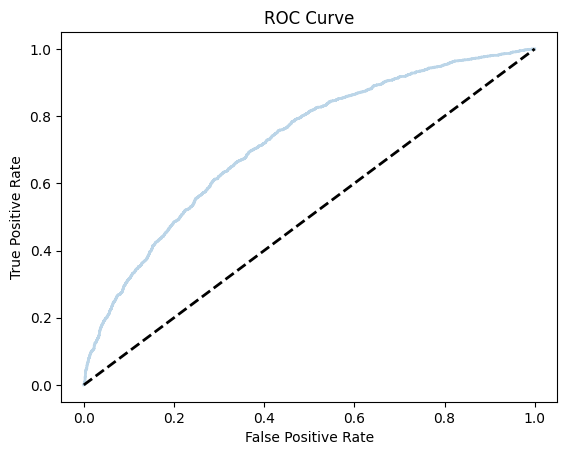

In [8]:
class MLP:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.evaluator = ModelEvaluator()

    def create_model(self, loss_func='mean_squared_error', optimizer='sgd', dropout_rate=0.3):
        model = Sequential()
        n_cols = self.X_train.shape[1]
        model.add(BatchNormalization(input_shape=(n_cols,)))
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(500, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(BatchNormalization())
        model.add(Dense(2, activation='softmax'))

        model.compile(loss=loss_func, optimizer=optimizer, metrics=['accuracy'])
        return model

    def train_model(self, model, epochs=50, batch_size=32):
        early_stopping_monitor = EarlyStopping(patience=50)
        history = model.fit(self.X_train.fillna(0).astype('float32'), self.y_train, validation_split=0.3,
                            epochs=epochs, batch_size=batch_size, callbacks=[early_stopping_monitor])
        return history

    def evaluate_model(self, model):
        train_brier_score = self.evaluator.brier_score(model.predict(self.X_train.fillna(0).astype('float32')), self.y_train)
        test_brier_score = self.evaluator.brier_score(model.predict(self.X_test.fillna(0).astype('float32')), self.y_test)
        y_pred = model.predict(self.X_test.fillna(0).astype('float32'))
        auroc = roc_auc_score(self.y_test, self.evaluator.get_prob_1(y_pred))

        print('MLP train Brier score:', train_brier_score,
              '\n test Brier score:', test_brier_score,
              '\n AUROC:', auroc)

        return train_brier_score, test_brier_score, auroc

    def plot_roc_curve(self, model):
        fpr, tpr, _ = roc_curve(self.y_test, self.evaluator.y_roc(model, self.X_test.fillna(0).astype('float32')))
        plt.plot(fpr, tpr, lw=2, alpha=0.3)
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()


mlp = MLP(X_train1, y_train1, X_test1, y_test1)

# Create and compile the MLP model with categorical cross-entropy loss
cce_mlp = mlp.create_model(loss_func='sparse_categorical_crossentropy', optimizer='sgd', dropout_rate=0.3)

# Train the model
history = mlp.train_model(cce_mlp, epochs=50, batch_size=32)

# Evaluate the model
train_brier_score, test_brier_score, auroc = mlp.evaluate_model(cce_mlp)

# Plot the ROC curve
mlp.plot_roc_curve(cce_mlp)


#### Multi Layer Perceptron from Categorical Cross Entropy and Optimizer Adam

In [9]:
class MLP:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.evaluator = ModelEvaluator()

        self.model = Sequential()

        n_cols = X_train.shape[1]

        self.model.add(BatchNormalization(input_shape=(n_cols,)))
        self.model.add(Dense(70, activation='linear'))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(50, activation='relu'))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(50, activation='relu'))
        self.model.add(Dropout(0.3))

        self.model.add(BatchNormalization())
        self.model.add(Dense(2, activation='softmax'))

        self.early_stopping_monitor = EarlyStopping(patience=50)
        adam = keras.optimizers.Adam(lr=.001, decay=2e-4)
        self.model.compile(loss='sparse_categorical_crossentropy',
                           optimizer='adam', metrics=['accuracy'])

    def train(self, epochs=200):
        history = self.model.fit(self.X_train.fillna(0).astype('float32'), self.y_train,
                                 validation_split=0.3, epochs=epochs,
                                 callbacks=[self.early_stopping_monitor])

    def evaluate(self):
        train_brier_score = self.evaluator.brier_score(
            self.model.predict(self.X_train.fillna(0).astype('float32')), self.y_train)
        test_brier_score = self.evaluator.brier_score(
            self.model.predict(self.X_test.fillna(0).astype('float32')), self.y_test)
        auroc = roc_auc_score(
            self.y_test, self.evaluator.y_roc(self.model, self.X_test.fillna(0).astype('float32')))

        print('MLP train Brier score:', train_brier_score,
              '\n test Brier score:', test_brier_score,
              '\n AUROC:', auroc)

        return train_brier_score, test_brier_score, auroc
mlp = MLP(X_train1, y_train1, X_test1, y_test1)
mlp.train()
mlp.evaluate()


Epoch 1/200


/Users/puddinpop/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


444/444 [==============================] - 5s 6ms/step - loss: 0.6970 - accuracy: 0.6402 - val_loss: 0.5582 - val_accuracy: 0.7061
Epoch 2/200
444/444 [==============================] - 2s 3ms/step - loss: 0.5816 - accuracy: 0.7019 - val_loss: 0.5433 - val_accuracy: 0.7209
Epoch 3/200
444/444 [==============================] - 1s 3ms/step - loss: 0.5613 - accuracy: 0.7097 - val_loss: 0.5396 - val_accuracy: 0.7245
Epoch 4/200
444/444 [==============================] - 2s 4ms/step - loss: 0.5565 - accuracy: 0.7152 - val_loss: 0.5387 - val_accuracy: 0.7256
Epoch 5/200
444/444 [==============================] - 2s 5ms/step - loss: 0.5515 - accuracy: 0.7170 - val_loss: 0.5377 - val_accuracy: 0.7255
Epoch 6/200
444/444 [==============================] - 3s 6ms/step - loss: 0.5493 - accuracy: 0.7205 - val_loss: 0.5349 - val_accuracy: 0.7235
Epoch 7/200
444/444 [==============================] - 3s 7ms/step - loss: 0.5478 - accuracy: 0.7207 - val_loss: 0.5374 - val_accuracy: 0.7238
Epoch 8/200

(0.17388670034557852, 0.17652019951129175, 0.7358651314139836)